#PROJECT : Analysis of Users Preferences between Android and iOS 
Here we'll implement a sentiment analysis analysisng preferences of users between Android and iOS.


In [1]:
import json, time, sys, io, pickle
import re
import tweepy
import nltk
import numpy as np
import hashlib
import glob
import math
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from decimal import *
from __future__ import division
from matplotlib import pyplot as plt
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

#Collecting twitter data

In [2]:
##Twiiter configuration information

access_token = "97387398-09aWi5l77s95Vy7Jag58WvQ1soy9TzoGCA0vruWH5"
access_token_secret = "ZzBHbF3LjXg7Wl40VIa6nJomv1TdwQW9Am1oQRzIW0RLN"
consumer_key = "Ii9orQvVcYDTzbk5feDFIuz1n"
consumer_secret = "MXTqped02xYhyuer6IpO2Rt2377MRGsTHhJQnMZ9aOagGrTLnD"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)


In [3]:
##This class uses Tweepy to download tweets from Twitter streaming API
class TweetsListener(tweepy.StreamListener):

    def __init__(self, filename=None, api=None):
        super(TweetsListener, self).__init__()
        self.num_tweets = 0
        self.filename = filename
        self.stopHashTagList = ["#androidgames","#gamesinsight"]
        
    def on_status(self, status): 
        text = status.text.encode('utf-8').strip().lower()
        if not any(x in text for x in self.stopHashTagList) and not text.startswith('rt') and not text.startswith('RT'):
            record = {'Text': text, 'Created At': str(status.created_at)}
            if self.num_tweets < 1000:
                try:
                    with open(self.filename, 'a') as f:
                        print text
                        pickle.dump(record,f)
                        self.num_tweets += 1
                    return True
                except BaseException as e:
                    print("Error on_status: %s" % str(e))
            else:
                return False
        
    def on_error(self, status):
        print 'Error on status', status

    def on_limit(self, status):
        print 'Limit threshold exceeded', status

    def on_timeout(self, status):
        print 'Stream disconnected; continuing...'

In [4]:
# stream = Stream(auth, TweetsListener(filename = 'data_android.json'))
# stream.filter(track=['android','androidvsios','iosvsandroid'],languages=['en'])

In [6]:
# stream = Stream(auth, TweetsListener(filename = 'data_ios.json'))
# stream.filter(track=['iphone','ios','androidvsios','iosvsandroid'],languages=['en'])

In [7]:
##This method reads all the tweets from the file
def readTweets(filename):
    list = []
    with open(filename, 'r') as f:
        for x in range(0,1000):
            list.append(pickle.load(f)['Text'])
    return list


#Calculating Sentiments using Naive Bayes as Classifier

In [8]:
##This method helps in tokenizing tweets with punctuations
def tokenize_with_punct(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is kept as separate tokens.
    Note that underscore (_) is not considered punctuation.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    text = re.sub(r'[\x85]',"",text)
    tokens = re.findall(r"[\w]+|[^\s\w]", text.lower())
    return tokens

In [9]:
##This method uses tokenize_with_punct and adds prefix to two subsequent terms after not
def tokenize_with_not(text):
    """Does the same thing as tokenize_with_punct, with the following difference:
    whenever the term 'not' appears, change the two subsequent tokens to have the prefix
    'not_' prior to the token. See the example below. You may call 
    tokenize_with_punct as a subroutine.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    ###TODO
    text = re.sub(r'[\x85]',"",text)
    tokens = tokenize_with_punct(text)
    i=0
    while i< len(tokens):
        if tokens[i] == "not":
            if(i+1 < len(tokens)):
                tokens[i+1] = 'not_' + tokens[i+1]
            if(i+2 < len(tokens)):
                tokens[i+2] = 'not_' + tokens[i+2]
            i = i+3
        else:
            i = i+1
    
    return tokens

In [10]:
#This code reads the tweets from the json file and writes them to the text file
def writeListToTextFile(list,filename):
    f = open(filename, "w")
    for item in list:
      print>>f, item

In [11]:
# list_android = readTweets('data_android.json')
# writeListToTextFile(list_android,'data_android.txt')
# list_ios = readTweets('data_ios.json')
# writeListToTextFile(list_ios,'data_ios.txt')

In [12]:
#reads a stopwords from a file and converts it into a list
stopWords = []
def getStopWordList(stopWordListFileName):
    stopWords.append('AT_USER')
    stopWords.append('URL')

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    #print line
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords
stopWords = getStopWordList('stopwords.txt')

In [13]:
#this method processes the tweets by removing URL's, username, additional white spaces and replaces hashtags
#normal words
def processTweet(tweet):
    # process the tweets
    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','AT_USER',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')
    return tweet
#end

#Read the tweets one by one and process it


In [14]:
def processTweetsAndSave(filename):
    fp = open(filename, 'r')
    fpn = open('process'+filename,'w')
    line = fp.readline()
    while line:
        processedTweet = processTweet(line)
        print>>fpn, processedTweet
        line = fp.readline()
    #end loop
    fp.close()

In [15]:
# processTweetsAndSave('data_android.txt')
# processTweetsAndSave('data_ios.txt')

In [16]:
def replaceTwoOrMore(s):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", s)

In [17]:
##gets the feature vector for a given tweet
##need to comapre with tokenize_with_not
##tokenize_normal
def tokenize_normal(tweet):
    featureVector = []
    words = set(tweet)
    for w in words:
        w = replaceTwoOrMore(w)
        w = w.strip('\'"?,.')
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
        if(w in stopWords or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return featureVector

In [18]:
featureList = []
def featureExtraction(filename, tokenizeFn = "tokenize_with_not"):
    tweets = []
    fp = open(filename,'r')
    line = fp.readline()
    while line:
        linearray = line.split('-',1)
        sentiment = linearray[0]
        tweet = linearray[1]
        processedTweet = (tweet)
        if tokenizeFn == "tokenize_with_not":
            featureVector = tokenize_with_not(processedTweet)
        elif tokenizeFn == "tokenize_normal":
            featureVector = tokenize_normal(processedTweet)
        featureList.extend(featureVector)
        tweets.append((featureVector,sentiment))
        line = fp.readline()  
    return(tweets,featureList)

In [19]:
##this method reads all the tweets froma file and returns a list of tweets 
def getStatisticsAboutTweets(filename):
    fp = open(filename,'r')
    tweets = []
    line = fp.readline()
    while line:
        tweets.append(line)
        line = fp.readline()
    return tweets

In [20]:
def extract_features(tweet):
    tweet_words = set(tweet)
    features = {}
    for word in featureList:
        features['contains(%s)' % word] = (word in tweet_words)
    
    return features

In [21]:
def plotBarGraph(classification1, classification2, dataRange, N=3):
    with PdfPages('naive_bayes_pdf.pdf') as pdf:
        index = np.arange(N)
        bar_width = 0.35
        fig, ax = plt.subplots()
        opacity = 0.4
        error_config = {'ecolor': '0.3'}

        rects1 = plt.bar(index, classification1, bar_width,
                         alpha=opacity,
                         color='b',
                         error_kw=error_config,
                         label='iOS')

        rects2 = plt.bar(index + bar_width, classification2, bar_width,
                         alpha=opacity,
                         color='r',
                         error_kw=error_config,
                         label='Android')

        plt.xlabel('Sentiment Classification')
        plt.ylabel('Number of tweets')
        plt.title('Sentiment Classification of Tweets')
        plt.xticks(index + bar_width, ('Positve', 'Neutral', 'Negative'))
        plt.yticks(dataRange)
        plt.legend()

        plt.tight_layout()
        plt.show()
        pdf.savefig(fig)

In [22]:
def predictUserPreferences_nb(trainFileName, testFileName,osType,tokenizeFn = "tokenize_with_not"):
    featureList = []
    os = ''
    if osType == 'iOS':
        os = 'iOS'
    elif osType == 'android':
        os = 'Android'
    predictedNegativeTweetsLabel = []
    predictedPositiveTweetsLabel = []
    predictedNeutralTweetsLabel = []
    if tokenizeFn == "tokenize_with_not":
        tweets,featureList = featureExtraction(trainFileName, tokenizeFn = 'tokenize_with_not')
    elif tokenizeFn == "tokenize_normal":
        tweets,featureList = featureExtraction(trainFileName, tokenizeFn = 'tokenize_normal')
    training_set =  nltk.classify.util.apply_features(extract_features, tweets)
    NBClassifier = nltk.NaiveBayesClassifier.train(training_set)
    analyzedTweets = getStatisticsAboutTweets(testFileName)
    print "Total tweets analyzed : " + str(len(analyzedTweets))
   
    for tweet in analyzedTweets:
        processedTestTweet = processTweet(tweet)
        if tokenizeFn == "tokenize_with_not":
            label = NBClassifier.classify(extract_features(tokenize_with_not(processedTestTweet)))
        elif tokenizeFn == "tokenize_normal":
            label = NBClassifier.classify(extract_features(tokenize_normal(processedTestTweet)))
        if label == 'n':
            predictedNegativeTweetsLabel.append((tweet,label))
        elif label == 'p':
            predictedPositiveTweetsLabel.append((tweet,label))
        elif label == 'ne':
            predictedNeutralTweetsLabel.append((tweet,label))
            
    percentPositive = (len(predictedPositiveTweetsLabel)/len(analyzedTweets)) * 100
    percentNegative = (len(predictedNegativeTweetsLabel)/len(analyzedTweets)) * 100
    percentNeutral = (len(predictedNeutralTweetsLabel)/len(analyzedTweets)) * 100
    print "Positive Percentage " + str(percentPositive)
    print "Negative Percentage " + str(percentNegative)
    print "Neutral Percentage " + str(percentNeutral)
    
    if(percentPositive > percentNegative):
        print "Users prefer "+os+" more!!"
    elif(percentPositive < percentNegative):
        print "Users dont prefer "+os+"!!"
    elif(percentPositive == percentNegative):
        print "User preferences are neutral"

    #plot graph
    classification = [len(predictedPositiveTweetsLabel),len(predictedNeutralTweetsLabel),len(predictedNegativeTweetsLabel)]
    
    return classification
#     plotBarGraph(classification,dataRange)
    

=======================Analysis of iOS tweets==========================
Total tweets analyzed : 500
Positive Percentage 15.2
Negative Percentage 3.4
Neutral Percentage 81.4
Users prefer iOS more!!
=======================Analysis of Android tweets==========================
Total tweets analyzed : 500
Positive Percentage 7.0
Negative Percentage 10.0
Neutral Percentage 83.0
Users dont prefer Android!!


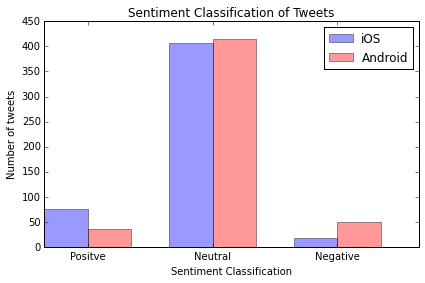

In [28]:
print "=======================Analysis of iOS tweets=========================="
classification1 = predictUserPreferences_nb('data/train_ios.txt','data/test_500ios.txt','iOS',tokenizeFn= "tokenize_with_not")
print "=======================Analysis of Android tweets=========================="
classification2 = predictUserPreferences_nb('data/train_android.txt','data/test_500android.txt','android',tokenizeFn= "tokenize_with_not")
dataRange = np.arange(0,500,50)
plotBarGraph(classification1,classification2,dataRange)

=======================Analysis of iOS tweets==========================
Total tweets analyzed : 1000
Positive Percentage 22.2
Negative Percentage 2.1
Neutral Percentage 75.7
Users prefer iOS more!!
=======================Analysis of Android tweets==========================
Total tweets analyzed : 1000
Positive Percentage 6.1
Negative Percentage 7.1
Neutral Percentage 86.8
Users dont prefer Android!!


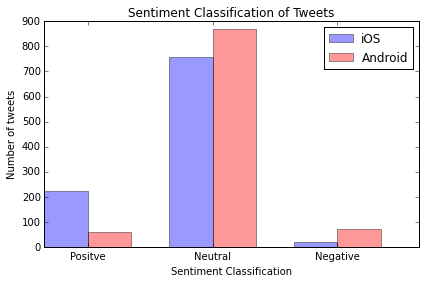

In [29]:
print "=======================Analysis of iOS tweets=========================="
classification1 = predictUserPreferences_nb('data/train_ios.txt','data/test_1000ios.txt','iOS',tokenizeFn= "tokenize_with_not")
print "=======================Analysis of Android tweets=========================="
classification2 = predictUserPreferences_nb('data/train_android.txt','data/test_1000android.txt','android',tokenizeFn= "tokenize_with_not")
dataRange = np.arange(0,1000,100)
plotBarGraph(classification1,classification2,dataRange)

=======================Analysis of iOS tweets==========================
Total tweets analyzed : 1500
Positive Percentage 21.2
Negative Percentage 1.46666666667
Neutral Percentage 77.3333333333
Users prefer iOS more!!
=======================Analysis of Android tweets==========================
Total tweets analyzed : 1500
Positive Percentage 6.06666666667
Negative Percentage 5.53333333333
Neutral Percentage 88.4
Users prefer Android more!!


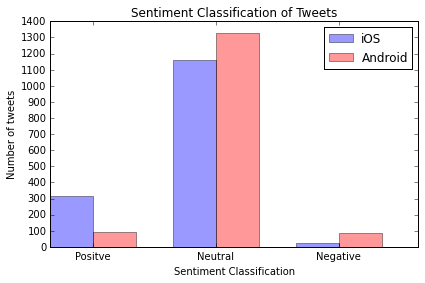

In [30]:
print "=======================Analysis of iOS tweets=========================="
classification1 = predictUserPreferences_nb('data/train_ios.txt','data/test_1500ios.txt','iOS',tokenizeFn= "tokenize_with_not")
print "=======================Analysis of Android tweets=========================="
classification2 = predictUserPreferences_nb('data/train_android.txt','data/test_1500android.txt','android',tokenizeFn= "tokenize_with_not")
dataRange = np.arange(0,1500,100)
plotBarGraph(classification1,classification2,dataRange)

# Calculating Sentiments with Logistic Regression as Classifier
Calculated sentiments seperately for android and iOS

In [31]:
trainiosfilename = 'data/train_ios.txt'
trainandroidfilename = 'data/train_android.txt'

In [32]:
def get_true_labels(file_name):
    """Return a *numpy array* of ints for the true sentiment labels of each file.
    1 means positive, 0 means negative, -1 means neutral. Use the name of the file to determine
    the true label.
    Params:
        file_name....file containing labelled tweets
    Returns:
        a numpy array of 1 or 0 values corresponding to each element
        of file_names, where 1 indicates a positive review, and 0
        indicates a negative review.
    """
    ###TODO
    array = []
    fp = open(file_name,'r')
    line = fp.readline()
    while line:
        linearray = line.split('-')
        if linearray[0] == 'p':
            array.append(1)
        elif linearray[0] == 'n':
            array.append(0)
        elif linearray[0] == 'ne':
            array.append(-1)
        line = fp.readline()
    values = np.array(array)
    return values
    ###

labels_ios = get_true_labels(trainiosfilename)
print('first 3 and last 3 labels are: %s' % str(labels_ios[[1,2,3,-3,-2,-1]]))
labels_android = get_true_labels(trainandroidfilename)
print('first 3 and last 3 labels are: %s' % str(labels_android[[1,2,3,-3,-2,-1]]))

first 3 and last 3 labels are: [ 0  0 -1 -1  0 -1]
first 3 and last 3 labels are: [-1 -1  0 -1 -1 -1]


In [33]:
def tokenize(text):
    """Given a string, return a list of tokens such that: (1) all
    tokens are lowercase, (2) all punctuation is removed. Note that
    underscore (_) is not considered punctuation.
    UPDATE: To be more specific, a token is a sequence of 
    alphanumeric characters, i.e., [A-Za-z0-9_]. Non-ascii characters
    are not considered to be part of tokens.
    Params:
        text....a string
    Returns:
        a list of tokens
    """
    text = re.sub(r'[\x85]',"",text)
    return re.sub('\W+', ' ', text.lower()).split()

tokenize("Hi! How's it going??? an_underscore is not *really* punctuation.")

['hi',
 'how',
 's',
 'it',
 'going',
 'an_underscore',
 'is',
 'not',
 'really',
 'punctuation']

In [34]:
def do_vectorize(filename, tokenizer_fn=tokenize_with_not, min_df=1,
                 max_df=1., binary=True, ngram_range=(1,1)):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        filenames.......list of review file names
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    fp = open(filename,'r')
    contentList = []
    line = fp.readline()
    while line:
        contentList.append(line)
        line = fp.readline()
    vectorizer = CountVectorizer(input = 'content', tokenizer = tokenizer_fn, max_df = max_df, min_df = min_df, binary = binary, dtype = int)
    X = vectorizer.fit_transform(contentList)
    return (X,vectorizer)

#vectorizing ios data   
matrixios, vecios = do_vectorize(trainiosfilename)
print ('matrix ios represents %d tweets with %d features' % (matrixios.shape[0], matrixios.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrixios[0].nonzero()[1]))))

#vectorizing android data
matrixandroid, vecandroid = do_vectorize(trainandroidfilename)
print ('matrix android represents %d tweets with %d features' % (matrixandroid.shape[0], matrixandroid.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrixandroid[0].nonzero()[1]))))

matrix ios represents 498 tweets with 1502 features
first doc has terms:
[12, 195, 265, 813, 817, 993, 1025, 1307, 1372]
matrix android represents 477 tweets with 1923 features
first doc has terms:
[2, 5, 12, 13, 14, 52, 235, 241, 242, 300, 306, 338, 487, 805, 857, 859, 967, 1124, 1177, 1249, 1509, 1526, 1585, 1698, 1713]


In [35]:
def repeatable_random(seed):
    hash = str(seed)
    while True:
        hash = hashlib.md5(hash).digest()
        for c in hash:
            yield ord(c)

def repeatable_shuffle(X, y, filenames):
    print X.shape[0]
    r = repeatable_random(42) 
    indices = sorted(range(X.shape[0]), key=lambda x: next(r))
    if indices == 477:
        print np.array(filenames)[indices]
        return X[indices], 0, np.array(filenames)[indices]
    return X[indices], y[indices], np.array(filenames)[indices]

# shuffling ios data
trainiosTweets = []
trainiOSFiles = open(trainiosfilename,'r')
trainiOSTweet = trainiOSFiles.readline()
while trainiOSTweet:
    trainiosTweets.append(trainiOSTweet)
    trainiOSTweet = trainiOSFiles.readline()

# shuffling android data  
X_ios, y_ios, filenames_ios = repeatable_shuffle(matrixios, labels_ios, trainiosTweets)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames_ios[0], y_ios[0], sorted(X_ios[0].nonzero()[1])))

trainandroidTweets = []
trainandroidFiles = open(trainandroidfilename,'r')
trainandroidTweet = trainandroidFiles.readline()
while trainandroidTweet:
    trainandroidTweets.append(trainandroidTweet)
    trainandroidTweet = trainandroidFiles.readline()

    
X_android, y_android, filenames_android = repeatable_shuffle(matrixandroid, labels_android, trainandroidTweets)

print('first shuffled document %s has label %d and terms: %s' % 
      (filenames_android[0], y_android[0], sorted(X_android[0].nonzero()[1])))

498
first shuffled document p-linkedin brings its refreshed â€˜voyagerâ€™ app to ios and android URL 
 has label 1 and terms: [12, 289, 292, 300, 380, 803, 826, 890, 1054, 1145, 1330, 1372, 1401, 1483, 1491, 1500, 1501]
477
first shuffled document n-apple https://t.co/zhzx2udjg3
 has label 0 and terms: [12, 13, 14, 241, 322, 487, 859, 1168, 1585, 1882]


In [36]:
def get_clf():
    return LogisticRegression(random_state=42)

In [37]:
def do_cross_validation(X, y, n_folds=3, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    cv = KFold(len(y), n_folds)
    i = 0
    accuracies = []
    for train_idx, test_idx in cv:
        clf = get_clf()
        clf.fit(X[train_idx], y[train_idx])
        predicted = clf.predict(X[test_idx])
        acc = accuracy_score(y[test_idx], predicted)
        if verbose :
            print("Fold {} accuracy = {}".format(i,acc))
        i = i + 1
        accuracies.append(acc)
    avg = np.mean(accuracies)
    return avg
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X_ios, y_ios, verbose=True))
print('average cross validation accuracy=%.4f' %
      do_cross_validation(X_android, y_android, verbose=True))

Fold 0 accuracy = 1.0
Fold 1 accuracy = 0.993975903614
Fold 2 accuracy = 1.0
average cross validation accuracy=0.9980
Fold 0 accuracy = 1.0
Fold 1 accuracy = 0.993710691824
Fold 2 accuracy = 1.0
average cross validation accuracy=0.9979


#Verifying Accuracies
of Logistic Regression for different combinations

In [38]:
def do_expt(filenames, y, tokenizer_fn=tokenize_with_not,
            min_df=10, max_df=1., binary=True,
            ngram_range=(1,1), n_folds=5,algorithm="LogisticRegression"):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        filenames.......list of review file names
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        max_df..........remove terms from the vocabulary that appear in more
                        than this fraction of documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        ngram_range.....A tuple (n,m) means to use phrases of length n to m inclusive.
                        E.g., (1,2) means consider unigrams and bigrams.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    matrix,vec=do_vectorize(filenames,tokenizer_fn, min_df, max_df, binary, ngram_range)
    if algorithm == "NaiveBayes":
        accuracy=do_cross_validation_naive(n_folds, verbose=False)
    elif algorithm == "LogisticRegression":
        accuracy = do_cross_validation(matrix,y,n_folds,verbose=False)
    return accuracy

In [39]:
print('accuracy using default settings for LogisticRegression: %.4g' % do_expt(trainiosfilename, y_ios))
print('accuracy using default settings for LogisticRegression: %.4g' % do_expt(trainandroidfilename, y_android))

accuracy using default settings for LogisticRegression: 0.8093
accuracy using default settings for LogisticRegression: 0.8009


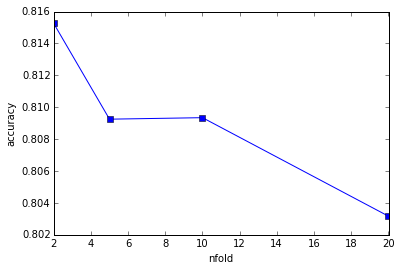

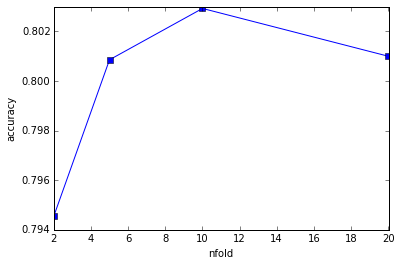

[0.79453957315143631,
 0.80085526315789468,
 0.80292553191489358,
 0.80099637681159419]

In [40]:
def compare_n_folds(filenames, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    ###TODO
    arr_nfolds = [2,5,10,20]
    accuracyList = []
    for nfold in arr_nfolds:
        accuracy = do_expt(filenames, y, n_folds = nfold)
        accuracyList.append(accuracy)
    plt.figure()
    plt.plot(arr_nfolds,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('nfold')
    plt.show()
    return accuracyList
    ###
    
compare_n_folds(trainiosfilename, y_ios)
compare_n_folds(trainandroidfilename, y_android)

In [41]:
def tokenizer_expt(y,filename):
    """
    How does the tokenizer affect results? 
    Call do_expt three times, using three different tokenizers:
    1- tokenize
    2- tokenize_with_punct
    3- tokenize_with_not
    Return the average cross-validation accuracy for each approach,
    in the above order. Use the default parameters for all other 
    arguments to do_expt.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies for each tokenizer.
    """
    accuracyList = []
    accuracyList.append(do_expt(filename,y,tokenizer_fn = tokenize))
    accuracyList.append(do_expt(filename,y,tokenizer_fn = tokenize_with_punct))
    accuracyList.append(do_expt(filename,y,tokenizer_fn = tokenize_with_not))
    return accuracyList

In [42]:
print "IOS"
print tokenizer_expt(y_ios,"data/train_ios.txt")
print "Android"
print tokenizer_expt(y_android,"data/train_android.txt")

IOS
[0.81531313131313132, 0.80925252525252522, 0.80925252525252522]
Android
[0.80293859649122812, 0.80293859649122812, 0.80085526315789468]


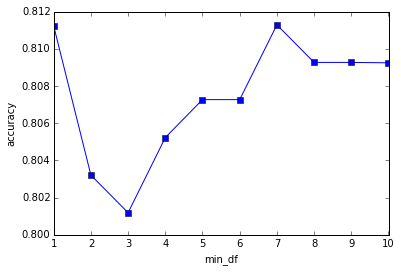

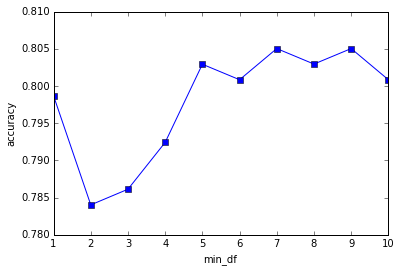

[0.79868421052631577,
 0.7840350877192982,
 0.78614035087719303,
 0.7924342105263158,
 0.80293859649122812,
 0.80085526315789468,
 0.80504385964912273,
 0.8029605263157894,
 0.80504385964912273,
 0.80085526315789468]

In [43]:
def min_df_expt(filenames, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,10) (inclusive). For each setting,
    call do_expt and store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function, except that the tokenizer
    should be tokenize_with_not.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    min_dfList = [1,2,3,4,5,6,7,8,9,10]
    accuracyList= []
    for min_df in min_dfList:
        accuracyList.append(do_expt(filenames,y,min_df=min_df,tokenizer_fn=tokenize_with_not))
    plt.figure()
    plt.plot(min_dfList,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('min_df')
    plt.show()
    return accuracyList

min_df_expt(trainiosfilename,y_ios)
min_df_expt(trainandroidfilename,y_android)

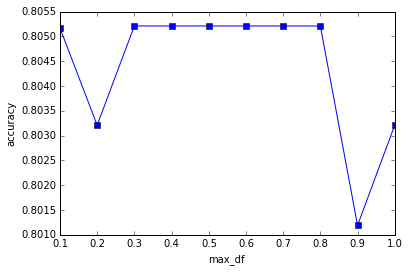

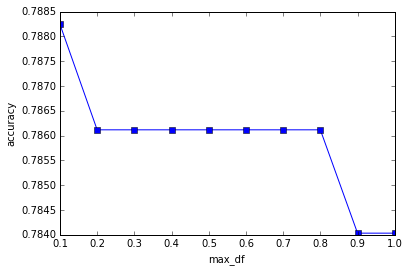

[0.78824561403508775,
 0.78611842105263163,
 0.78611842105263163,
 0.78611842105263163,
 0.78611842105263163,
 0.78611842105263163,
 0.78611842105263163,
 0.78611842105263163,
 0.7840350877192982,
 0.7840350877192982]

In [44]:
def max_df_expt(filenames, y):
    """
    Vary the setting of max_df parameter in the do_expt 
    function to be one of [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.].
    For each setting, call do_expt and store the resulting accuracy.
    Plot the accuracies for each setting. Also return the list of accuracies.
    Use the default value for all other arguments to the do_expt function,
    except that the tokenizer=tokenize_with_not and min_df=2.
    Params:
        filenames....list of training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per max_df value.
    """
    max_dfList = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]
    accuracyList= []
    for max_df in max_dfList:
        accuracyList.append(do_expt(filenames,y,max_df=max_df, min_df = 2, tokenizer_fn=tokenize_with_not))
    plt.figure()
    plt.plot(max_dfList,accuracyList, marker="s")
    plt.ylabel('accuracy')
    plt.xlabel('max_df')
    plt.show()
    return accuracyList

max_df_expt(trainiosfilename,y_ios)
max_df_expt(trainandroidfilename,y_android)

In [57]:
# training classifier using the optimal settings
X_ios, vec_ios = do_vectorize(trainiosfilename, tokenizer_fn=tokenize_with_not,
                      binary=True, min_df=7, max_df=.1)
clf_ios = get_clf()
clf_ios.fit(X_ios, y_ios)

X_android, vec_android = do_vectorize(trainandroidfilename, tokenizer_fn=tokenize_with_not,
                      binary=True, min_df=7, max_df=.1)
clf_android = get_clf()
clf_android.fit(X_android, y_android)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

In [71]:
def test_new_data(filename,typeOftest):
    fp = open(filename,'r')
    contentList = []
    line = fp.readline()
    while line:
        contentList.append(line)
        line = fp.readline()
    if typeOftest == "ios":
        X_test = vec_ios.transform(contentList)
        print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
        predicted = clf_ios.predict(X_test)
        return predicted
    elif typeOftest == "android":
        X_test = vec_android.transform(contentList)
        print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
        predicted = clf_android.predict(X_test)
        return predicted

In [79]:
def getLogisticRegressionResults(filename,osType):
    result = test_new_data(filename,osType)
    positiveTweets = 0
    negativeTweets = 0
    neutralTweets = 0
    totalTweetsAnalyzed = len(result)
    for arr in result:
        if arr == -1:
            neutralTweets += 1
        elif arr == 0:
            negativeTweets += 1
        elif arr == 1:
            positiveTweets += 1
    percentPositive = ((positiveTweets)/(totalTweetsAnalyzed)) * 100
    percentNegative = ((negativeTweets)/(totalTweetsAnalyzed)) * 100
    percentNeutral = ((neutralTweets)/(totalTweetsAnalyzed)) * 100
    print "Positive Percentage " + str(percentPositive)
    print "Negative Percentage " + str(percentNegative)
    print "Neutral Percentage " + str(percentNeutral)
    
    if(percentPositive > percentNegative):
        print "Users prefer "+osType+" more!!"
    elif(percentPositive < percentNegative):
        print "Users dont prefer "+osType+"!!"
    elif(percentPositive == percentNegative):
        print "User preferences are neutral"
    return [positiveTweets, neutralTweets, negativeTweets]

=======================Analysis of android tweets==========================
X_test represents 500 documents with 138 features
Positive Percentage 0.2
Negative Percentage 0.0
Neutral Percentage 99.8
Users prefer android more!!
=======================Analysis of iOS tweets==========================
X_test represents 500 documents with 137 features
Positive Percentage 0.4
Negative Percentage 0.0
Neutral Percentage 99.6
Users prefer ios more!!


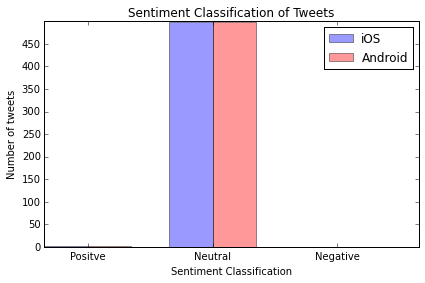

In [83]:
print "=======================Analysis of android tweets=========================="
classification1 = getLogisticRegressionResults('data/test_500android.txt',"android")
print "=======================Analysis of iOS tweets=========================="
classification2 = getLogisticRegressionResults('data/test_500ios.txt',"ios")
dataRange = np.arange(0,500,50)
plotBarGraph(classification1,classification2,dataRange)
    

=======================Analysis of Android tweets==========================
X_test represents 1000 documents with 138 features
Positive Percentage 0.5
Negative Percentage 0.0
Neutral Percentage 99.5
Users prefer android more!!
=======================Analysis of iOS tweets==========================
X_test represents 1000 documents with 137 features
Positive Percentage 0.3
Negative Percentage 0.0
Neutral Percentage 99.7
Users prefer ios more!!


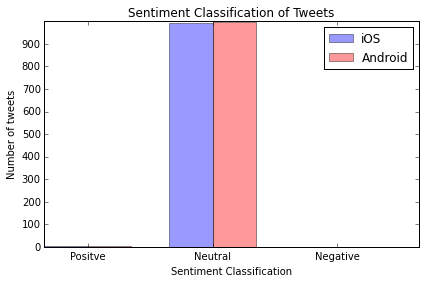

In [84]:
print "=======================Analysis of Android tweets=========================="
classification1 = getLogisticRegressionResults('data/test_1000android.txt',"android")
print "=======================Analysis of iOS tweets=========================="
classification2 = getLogisticRegressionResults('data/test_1000ios.txt',"ios")
dataRange = np.arange(0,1000,100)
plotBarGraph(classification1,classification2,dataRange)

=======================Analysis of Android tweets==========================
X_test represents 1500 documents with 138 features
Positive Percentage 0.466666666667
Negative Percentage 0.0
Neutral Percentage 99.5333333333
Users prefer android more!!
=======================Analysis of iOS tweets==========================
X_test represents 1500 documents with 137 features
Positive Percentage 0.733333333333
Negative Percentage 0.0666666666667
Neutral Percentage 99.2
Users prefer ios more!!


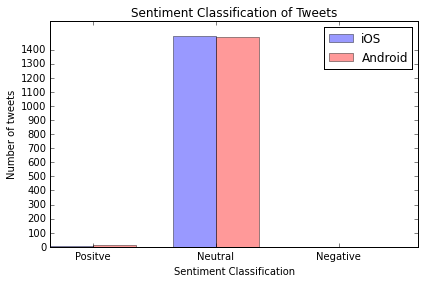

In [85]:
print "=======================Analysis of Android tweets=========================="
classification1 = getLogisticRegressionResults('data/test_1500android.txt',"android")
print "=======================Analysis of iOS tweets=========================="
classification2 = getLogisticRegressionResults('data/test_1500ios.txt',"ios")
dataRange = np.arange(0,1500,100)
plotBarGraph(classification1,classification2,dataRange)

#Conclusion - 
Naive Bayes classifier gives more correct classification for smaller datasets.
Logistic regression starts to show some result for 1500 tweets.
Also, we have a lot of neutral tweets in our data set, that also affects logistic regression, as logistic regression is generally preferred for boolean data sets